In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math

from basic_artificial_market import ArtificialMarket

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import math

class ArtificialMarket():
    def __init__(self, num_player=1000, fdmtl=10000.0, ganma=1, sigma=0.06, P_sigma=30):
        self.num_player = num_player
        self.random_state = np.random.RandomState()
        self.fdmtl = fdmtl
        self.sigma = sigma
        self.P_sigma = P_sigma
    
    def weight(self, w_1_max=1, w_2_max=10, w_3_max=1):
        num_player = self.num_player
        weight_1 = np.zeros(num_player)
        weight_2 = np.zeros(num_player)
        weight_3 = np.zeros(num_player)
        random_state = self.random_state
        for i in range(num_player):
            weight_1[i] = random_state.uniform()*w_1_max
            weight_2[i] = random_state.uniform()*w_2_max
            weight_3[i] = random_state.uniform()*w_3_max
        weight = [weight_1, weight_2, weight_3]
        return weight
    
    def ganma(self, ganma_max=10000, num_player=None):
        random_state = self.random_state
        if num_player is None:
            num_player = self.num_player
        ganma = np.array([])
        for i in range(num_player):
            ganma = np.append(ganma, int(random_state.uniform(ganma_max)))
        return ganma
    
    def P_t(self, past_data, delta_l, delta_t):
        if np.sum(delta_t) <= delta_l:
            P_t = past_data[-1]
        else: 
            d = 0
            j = 0
            while d <= delta_l:
                j += 1
                d += delta_t[-j]
            P_t = past_data[-j]
        return P_t
    
    def r_t_h(self, past_data, P_t, ganma):
        if len(past_data) < ganma:
            past_data_ganma = past_data[0]
            r_t_h = np.log(P_t/past_data_ganma)
        else:
            past_data_ganma = past_data[-ganma]
            r_t_h = np.log(P_t/past_data_ganma)
        return r_t_h

    def one_market_model(self, w, delta_l=0, past_data=None, delta_t=None, b_limit=None, s_limit=None, ganma_max=10, market_order=0, nottrading=False):
        delta = 1
        num_player = self.num_player
        sigma = self.sigma
        P_sigma = self.P_sigma
        P_f = self.fdmtl
        
        if past_data is None:
            past_data = [P_f]
        if b_limit is None:
            b_limit = []
        if s_limit is None:
            s_limit = []
        if delta_t is None:
            delta_t = np.array([])
            
        P_t_1 = past_data[-1]
        w_1 = w[0]
        w_2 = w[1]
        w_3 = w[2]
        
        r_t_e = np.zeros(num_player)
        
        ganma = self.ganma()
    
        for i in range(num_player):
            P_t_1 = self.P_t(past_data, delta_l, delta_t)
            
            r_t_h = self.r_t_h(past_data, P_t_1, ganma[i]) 
            
            e_t = np.random.normal(0, sigma)
            r_t_e[i] = (w_1[i]*np.log(P_f/P_t_1) + w_2[i]*r_t_h + w_3[i]*e_t)/(w_1[i] + w_2[i] + w_3[i])
            
            P_e = P_t_1*math.exp(r_t_e[i])
            P_o = np.random.normal(P_e, P_sigma)
            
            if nottrading is True:
                P_e = 10000
            
            if P_e > P_o:
                P_o = round(P_o, 1)
                if len(s_limit) > 0 and np.min(s_limit) < P_o and nottrading is False:
                    P_t = np.min(s_limit)
                    s_limit = np.delete(s_limit, np.argmin(s_limit))
                    market_order += 1
                else:
                    b_limit = np.append(b_limit, P_o)
                    P_t = P_t_1
            else:
                P_o = round(P_o, 1)+0.1
                if len(b_limit) > 0 and np.max(b_limit) > P_o and nottrading is False:
                    P_t = np.max(b_limit)
                    b_limit = np.delete(b_limit, np.argmax(b_limit))
                    market_order += 1
                else:
                    s_limit = np.append(s_limit, P_o)
                    P_t = P_t_1
            past_data = np.append(past_data, P_t)
            delta_t = np.append(delta_t, np.random.exponential(delta))
        return past_data, delta_t, b_limit, s_limit, market_order
        
    def one_market_simulation(self, delta_l=0, t_max=100000, fdmtl=10000.0):
        w = self.weight()
        t = 0
        for i in range(2):
            past_data, delta_t, b_limit, s_limit, market_order = self.one_market_model(w, delta_l, nottrading=True)
        past_data = np.array([fdmtl])
        delta_t = np.array([0])
        while t < t_max:
            past_data, delta_t, b_limit, s_limit, market_order = self.one_market_model(w, delta_l, past_data, delta_t, b_limit, s_limit, market_order)
            t = len(delta_t)
        return past_data, market_order
    
    def rad(self, past_data, fdmtl=10000.0):
        p = 0
        for i in range(len(past_data)):
            p += math.fabs(past_data[i] - fdmtl)/fdmtl
        m = p/float(len(past_data))
        return m

    def agreed_rate(self, past_data, market_order):
        agreed_rate = float(market_order)/float(len(past_data))
        return agreed_rate
    
    def volatility(self, past_data):
        v = np.std(past_data)
        return v
        
    def kurtosis(self, past_data):
        s = 0
        avr_past_data = np.average(past_data)
        for i in range(len(past_data)):
            s +=  pow((past_data[i] - avr_past_data), 4)
        k = s/(len(past_data)*pow(np.std(past_data), 4)) - 3
        return k
       
    def main(self, delta_l=0, t_max=100000):
        past_data, market_order = self.one_market_simulation(delta_l, t_max)
        plt.plot(past_data)
        r = self.rad(past_data)
        a = self.agreed_rate(past_data, market_order)
        v = self.volatility(past_data)
        k = self.kurtosis(past_data)
        print r, a, v, k
        

出力結果は左から、市場非効率性、約定率、ボラティリティー、尖度。
グラフは取引価格の推移。

上からレイテンシーδｌ/δo＝0，0,1, 0,5, 1, 3, 5, 10とした。

0.00268091929081 0.00312996870031 30.7313522207 -0.564515384153


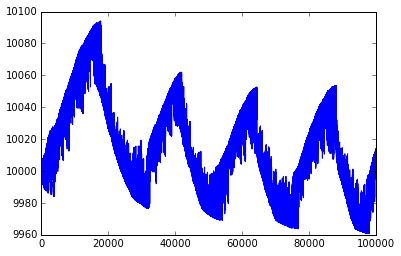

In [39]:
AM = ArtificialMarket()
AM.main(0, 100000)

0.00352089949101 0.00339996600034 44.7892404441 0.249859991795


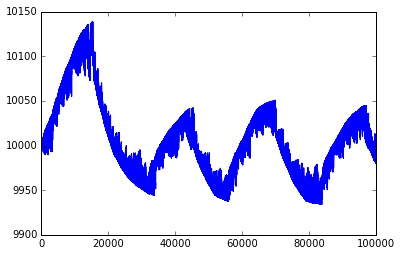

In [40]:
AM.main(0.1, 100000)

0.0032105104949 0.00317996820032 36.2374329723 -0.862334109073


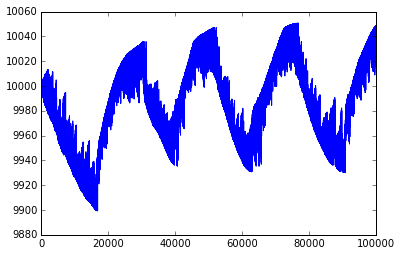

In [41]:
AM.main(0.5, 100000)

0.00258567114329 0.00322996770032 30.3917962494 -0.991955203414


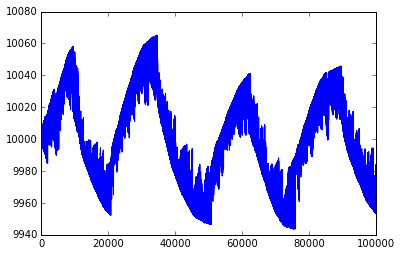

In [7]:
AM = ArtificialMarket()
AM.main(1, 100000)

0.00302644523555 0.00341996580034 34.1227063188 -0.31291920791


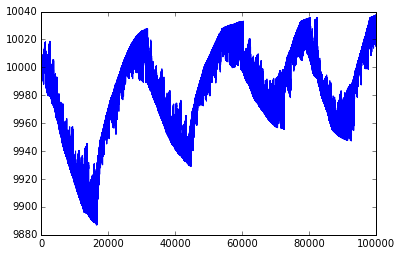

In [42]:
AM.main(3, 100000)

0.00368790272097 0.00339996600034 43.3286971836 -0.570190650846


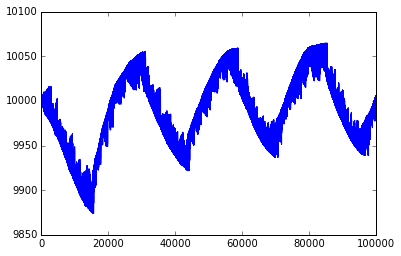

In [43]:
AM.main(5, 100000)

0.00323816571834 0.00274997250027 37.1369902185 -0.684886905879


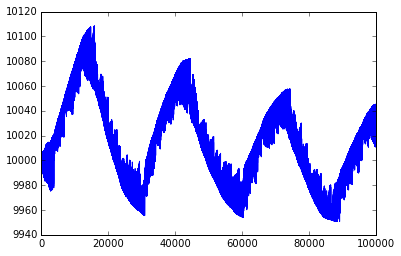

In [44]:
AM.main(10, 100000)

In [49]:
1-711.915/801.000

0.1112172284644195